# Paper Information
Paper: SinGAN: Learning a Generative Model from a Single Natural Image, https://arxiv.org/abs/1905.01164

Authors: Tamar Rott Shaham, Tali Dekel, Tomer Michaeli

Code Authors: Ataberk Dönmez, Deniz Sayın 

# Paper Summary

## Introduction

SinGAN is an unconditional generative model that learns from a single natural image. The model is trained on the internal statistics of the image, and is then able to generate high quality random samples with content similar to the provided image. It is also possible to use the model for different purposes such as super-resolution, harmonization, smooth image editing as well as single image animations. The random sampling examples shown at the beginning of the paper (Figure 1) are shown here:

![alt text](notebook-images/fig1.png "Random Samples")

## Method

### Architecture

Since the statistics of the training image need to be captured at multiple different scales to be effective, the SinGAN architecture is a multi-scale one. With $N$ scales present, the architecture consists of a single generator and a single discriminator (critic) at each scale. 

The highest generator-discriminator pair work on the original sized image, and the size of the image is decreased at as we go down in the number of scales. At the coarsest scale, the generator and discriminator work on very small images. As an example, when using 9 scales with an 250x250 input and a scaling factor of 0.75 at each scale, the coarsest scale would work with images of size 25x25. 

The job of the discriminator is simply discriminating in its own scale, the discriminators at every scale are independent of each other. 

However, the scales work in a cascaded manner for generation: First, the generator of the coarsest scale (minimum input/output size) generates a small image from noise in a purely generative fashion. Then, this output image is upsampled, mixed with noise and passed as input to the generator of the next scale. Intuitively, this next generator uses the output of the coarser scale as a base and the noise to add extra details. The output of this scale is then passed to the next scale which adds even finer details, and this repeats until the final scale, which produces an image with the same size as the original, is reached. Thus, the inputs and output $\tilde{x}_i$ of the generators $G_i$ can be represented as follows where $z_i$ represents the input noise at the $i$th scale with zero being the coarsest:

$$
\tilde{x}_0 = G_0(z_0) \\
\tilde{x}_i = G_i(z_i, \mathrm{upsample}(\tilde{x}_{i-1})), \ i > 0
$$

A simple 5 layer CNN is used for both the generator and discriminator, including batch normalization and using LeakyReLU as the activation function. The final layer of the generator uses $\mathrm{tanh}$ to limit the output range while the final layer of the discriminator has no activation. 

The architecture of each generator and discriminator changes very little at each scale. Only the number of filters are increased to increase the capacity of the model: they are doubled once every four scales. In particular, careful attention is paid to keeping the perceptual field size of the network constant: 11x11 at every scale. As the image gets larger at each scale, the 11x11 perceptual field represents a smaller percentage of the image, which is why the lower scales generate more of the global structure while the higher scales add finer details. Another advantage of the small perceptual field is that it prevents the network from memorizing the full training image. 

The SinGAN architecture is illustrated below (Figure 4 from the original paper):

![alt text](notebook-images/fig4.png "SinGAN Architecture")

### Training

Each generator-discriminator pair is trained in sequence, starting from the coarsest scale. When a pair finishes training, its weights are fixed and then the training switches to the next pair. The loss function for each pair consists of an adversarial loss and a reconstruction loss:

$$
\mathcal{L}_i = \min_{G_i} \max_{D_i} \mathcal{L}_{adv}(G_i, D_i) + \alpha \mathcal{L}_{rec}(G_i)
$$
                        
**Adversarial Loss:** The generator simply takes an image (possibly pure noise) as input and generates another image of the same size, with values in the range $(-1, 1)$ due to the $\mathrm{tanh}$ activation. The discriminator is a patch discriminator, which outputs a discrimination score for each 11x11 patch in the image, and the mean of each patch's score is used as the final score. WGAN-GP loss is used  rather than the standard formulation, which tries to enforce 1-Lipschitzness for the discriminator by enforcing the gradients of the discriminator to be close to one on the input manifold. The formulation of the loss is as follows, where $P_g$ is the generator's output distribution, $P_r$ is the real data distribution and $P_\hat{x}$ is the distribution of points in straight lines between real and generated example pairs:

$$
\begin{align}
\mathcal{L}_{adv}(G, D) &= \underset{\tilde{x} \sim P_g}{\mathbb{E}}[D(\tilde{x})] - \underset{x \sim P_r}{\mathbb{E}}[D(x)] + \lambda \underset{\hat{x} \sim P_{\hat{x}}}{\mathbb{E}}[(||\nabla_{\hat{x}}D(\hat{x})||_2 - 1)^2]
\end{align}
$$

**Reconstruction Loss:** The goal here is to ensure that the original image can be reconstructed when given specific set of noise images as input: A particular noise image $z^*$ is selected as input to the coarsest scale while the noise is set to zero for all other scales. The output is expected to be the same as the original image in this case, and enforced with MSE loss. We can formulate this loss as follows, with $x_i$ being the rescaled original image and $\tilde{x}_i^{rec}$ being the reconstructed original image at the $i$th scale:

$$
\mathcal{L}_{rec}(G_0) = ||G_0(z^*) - x_0||_2^2 \\
\mathcal{L}_{rec}(G_i) = ||G_i(0, \mathrm{upsample}(\tilde{x}_{i-1}^{rec})) - x_i||_2^2, \ i > 0
$$

**Other Details:** 
- When moving on to the next scale, the weights of the new networks are initialized with the trained weights of the previous scale if the number of filters in the architecture did not change. Otherwise, they are initialized randomly as usual.
- At each scale, the RMSE between the upsampled reconstructed image at the previous scale and the original image at the current scale is used to scale the standard deviation of the input noise. Intuitively, the RMSE is an indicator of how much detail needs to be added to the previous scale's reconstruction to achieve high fidelity.

## Evaluation

Qualitative results can be found in the original paper and supplementary material. A short summary of quantitative results follows.

### Effects of Scales

An alternative generation strategy where a downsampled version of the original image is input to a generator in one of the upper scales is tested. This is in contrast to starting the generation from scratch. For example, when inserting the downsampled original image to scale number one, more of the global structure is preserved with much less noticeable variations being present in the output. This is further accentuated when using an even higher scale such as the second one where the output is barely different from the original. Thus, it is possible to change how much of the global structure of the original image is preserved with this technique, and this also forms the base of some of the other applications of SinGAN. This is illustrated in Figure 8 in the paper.

The effect of training with fewer scales is also examined. As expected, with fewer scales, the models fail to change global structures due to the small perceptual field and instead only capture textures. With a larger number of scales, global structures are successfully captured and modified as illustrated in Figure 9 in the paper.

### AMT Perceptual Study

In this first result, the authors take 50 different real images, and pair them with one selected random sample from a model trained on the corresponding image. Then, two different tests are performed in Amazon Mechanical Turk with 50 participants:
- Real vs Fake: Participants see a real and generated image pair for one second, and have to decide which one is real.
- Real or Fake: Participants see an image for one second, and have to decide whether it is real or fake.

Authors perform this with images generated from scratch, and also repeat the experiment with images generated starting from the downsampled original image at the second scale. Confusion values are reported in Table 1 in the paper. As expected, participants can usually differentiate in the vs. test, but usually fail in the or test.

### Single Image Fréchet Inception Distance (SIFID)

Since no datasets are present, the authors propose SIFID to compare the statistics of the generated images with the corresponding real image. Rather than fitting a Gaussian over the features of whole datasets as in FID, they simply fit the Gaussian over the features of the original image and generated images and compare those; and also calculate the correlation between the SIFID results and the previously performed perceptual study. Results are reported in Table 2 of the original paper. The correlation coefficient between SIFID and the paired survey results is around -0.55, while being only -0.25 for the unpaired survey.

## Applications

### Super-Resolution

SinGAN can be used for super-resolution (by a factor of $s$) with two modifications:
- The default reconstruction loss multiplier of 10 is increased by factor of 10 and becomes 100.
- The the pyramid scale factor is set as $\sqrt[k]{s}$ for some $k$.

Then, the model is trained on the low resolution image. For super-resolution, the low resolution image is upsampled and injected to the final generator $G_N$. The output is then re-injected to $G_N$. This process is repeated $k$ times to obtain the final output. 

Results are shown in Figure 10 in the paper. The intuition behind this approach is not explained very well in the paper.

### Paint-to-Image

Transferring simple clipart into a realistic image is another possible application. To do this, the model is trained on the real image, and then the clipart is downsampled and fed into one of the coarser scales (index 1 or 2). This allows the clipart to dictate the global structure while the model fills in the missing details necessary to make it look like the realistic image. 

Some results can be seen in Figure 11 in the original paper.

### Harmonization

Blending a given object into an image is one more application of SinGAN. In a similar way to the paint-to-image approach, the model is first trained on the original background image. Then, the object is naively pasted onto the original image, the result is downsampled and injected into the model. Once again, the naive-pasted version dictates the global structure and the model fills in missing details.

Example outputs are available in Figure 13 of the original paper.

### Editing

An additional use is to smooth a composite image in which some parts of an image have been copied and pasted into different parts of the image. Once again, the model is trained on the original image, and then the copy-pasted composite is downsampled and fed into the model. Finally, the output at the copy-pasted regions is combined with the original image to produce a smoothed composite. 

One illustration of this application is shown in Figure 12.

### Single Image Animation

The final application is creating a short video clip from a single image. To do this, a random walk is performed on the input noise starting from the specific reconstruction noise. An image is generated at each step and then these are combined sequentially to form a short animated clip. 

Some examples are shown in a video linked in the paper: https://youtu.be/xk8bWLZk4DU.



# Code Flow

- Module imports
- Device selection (CPU/GPU)

**Training:**
- Set hyperparameters for training, as well as the input image etc.
- Load the input image, resize its long edge if necessary
- Create a scale pyramid from the input image, corresponding to the output size of each scale
- Select a specific noise to be used in the reconstruction of the original image
- For each scale:
    - If this is not the coarsest scale:
        - Calculate RMSE between the upsampled reconstruction at the previous scale and the original image at the current scale
        - Double the number of filters in each layer if the scale index is divisible by four
        - Add a zero noise map to the list of reconstruction noise inputs
    - Create a noise sampler for the generator with stdev based on RMSE or a constant for the coarsest scale
    - Create a new generator, copy weights from previous scale if possible
    - Add the new generator to the stack of generators and connect them together, freezing all previous generators
    - Create a new critic, copy weights from previous scale if possible
    - For n iterations:
        - Update the critic a few times:
            - Sample a fake image with the generator
            - Use an interpolation between the original and fake image to calculate the gradient penalty
            - Pass the fake image and original image through the critic, subtract the mean of the results to obtain the adversarial loss
            - Sum the adversarial loss and gradient penalty and update the critic
        - Update the generator a few times:
            - Sample a fake image with the generator
            - Pass the fake image through the critic, take the mean and negate the output to obtain the adversarial loss
            - Input the reconstruction noise to obtain the reconstruction, MSE with the scaled original to obtain the reconstruction loss
            - Sum the adversarial and reconstruction losses and update the generator
        - Maybe show some intermediate results once every k iterations
    - Save the model

**Qualitative Results:**
- Set some parameters such as output size, input scale, samples per model, model directory etc.
- Go through all pre-trained models in the given directory:
    - Load the model with the given parameters
    - Sample as many images as required 
    - Show the sampled images in a new row next to the original image of the model using subplots
    
**Quantitative Results:**
- Maybe downgrade scipy to ensure proper operation
- Load the inception model for calculating FID
- Calculate FID on the authors' dataset to reproduce paper results and prove correctness of implementation
- Set some parameters for calculating our own SIFID
- Go through all pre-trained models in the given directory:
    - Load the model with the given parameters
    - Go through all required input scales:
        - Calculate average SIFID between original images and samples for this specific model, store the results
- Format the SIFID results into a table showing the average SIFID of each model, as well as the total average over all models at each input scale; illustrating that the results are similar to the original paper's

# Initialization & Hyperparameters

The module imports and device selection sections must always be run before being able to run any of the other sections.

## Module Imports

In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# our own helper modules
from models import *
from utils import *

## Device Selection

In [2]:
# arguments cell
DEVICE = 'cuda'

## Training Hyperparameters

Please note that running this cell and setting the parameters is only necessary for training, generating the results does not require any of these parameters.

In [0]:
# arguments cell
# image to train on
IMG_PATH = 'images/birds.png'
SAVE_PATH = 'models/birds.pt'

# training hyperparameters, 
# as given in the paper (and supplementary material)
GEN_LEARNING_RATE = 0.0005
CRIT_LEARNING_RATE = 0.0005
BETA_1 = 0.5  # beta parameters for the ADAM optimizer
BETA_2 = 0.999
NUM_ITERS = 2000  # number of iterations at each scale
LR_DROP_STEP = 1600  # step at which to decay learning rate
LR_DROP_MULT = 0.1  # lr decay multiplier
GEN_STEP_PER_ITER = 3  # optimization step per iteration for the generator
CRIT_STEP_PER_ITER = 3  # ... and the critic
REC_ALPHA = 10.0  # reconstruction loss weight
GP_WEIGHT = 0.1  # gradient penalty weight

# architecture details
NUM_SCALES = 9  # number of training scales, the most important parameter!
KERNEL_SIZE = 3  # kernel size of the convolutions, no need to change
NUM_BLOCKS = 5  # number of blocks in each network, no need to change
INITIAL_KERNEL_COUNT = 32  # the initial amount of kernels in each conv layer
INCREASE_KERNEL_COUNT_EVERY = 4  # ... and how often to double their amount (in scales)
NOISE_BASE_STD = 0.5  # base noise stdev multiplier at upper scales (scaled with rmse), different values in the range [0.1, 1.0] seem to work
FIRST_SCALE_NOISE_STD = 1.0  # noise stdev at the first scale, standard normal, different because there is no input image
MAX_INPUT_SIZE = 250  # if the input image is larger than this, resize its long edge preserving aspect ratio
UPSAMPLING_FACTOR = 4/3  # the factor by which images are upsampled at each scale
UPSAMPLING_MODE = 'bilinear'  # mode used when upscaling during training
DOWNSAMPLING_MODE = 'bicubic'  # mode used when downscaling the original input

# extra settings
PRINT_EVERY = 500  # show progress every X iterations
SEED = 796  # random seed value

# Training & Saving a Model

Takes between half an hour and a few hours depending on the GPU you have access to. Training a full model using only a CPU is not viable!

In [0]:
# training cell
# closures for easy use depending on settings, so that
# we can skip providing every single argument at each iteration
def make_generator(kernel_count, noise_std):
  sgnet = SGNet(NUM_BLOCKS, kernel_count, KERNEL_SIZE, final_activation=nn.Tanh(), output_channels=3).to(DEVICE)
  return SGGen(sgnet, noise_std)
  
def make_critic(kernel_count):
  return SGNet(NUM_BLOCKS, kernel_count, KERNEL_SIZE, final_activation=None, output_channels=1).to(DEVICE)

def make_optimizer_and_scheduler(net, net_learning_rate):
  optimizer = torch.optim.Adam(net.parameters(), net_learning_rate, (BETA_1, BETA_2))
  sched = torch.optim.lr_scheduler.StepLR(optimizer, LR_DROP_STEP, LR_DROP_MULT)
  return optimizer, sched

Image size is 164x244
Input image:


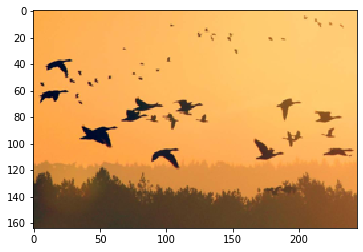

In [0]:
# training cell
# load the image along with its downsampled versions and their exact sizes
downsampling_factor = 1.0 / UPSAMPLING_FACTOR
scaled_origs, exact_sizes = load_with_reverse_pyramid(IMG_PATH, MAX_INPUT_SIZE, downsampling_factor, NUM_SCALES, 
                                                      mode=DOWNSAMPLING_MODE, device=DEVICE, verbose=True)
  
original_image = scaled_origs[-1]
print('Input image:')
plt.imshow(normed_tensor_to_np_image(original_image))
plt.show()

In [0]:
# training cell
# seed stuff
seed_rngs(SEED)

# create the scaled images
coarsest_exact_size = exact_sizes[0]

# initialize the constant noise used in reconstruction
z_rec_coarsest = FIRST_SCALE_NOISE_STD * torch.randn_like(scaled_origs[0], device=DEVICE)
z_rec = [z_rec_coarsest] # a zero tensor is appended after each scale

# constant zero input for the coarsest scale during training
coarsest_zero_input = torch.zeros_like(z_rec_coarsest)


****************************
Scale 0
Generator norms: G0: 37.860
Critic norms: C0: 37.464
Step: 0
Generator adv: 0.125, rec: 0.350
Critic fake: -0.130 real: -0.122 grad: 0.290


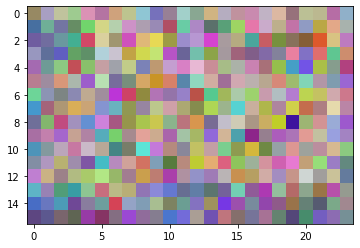

Step: 500
Generator adv: -0.906, rec: 0.001
Critic fake: 0.920 real: -1.410 grad: 1.204
Steps per second: 13.67


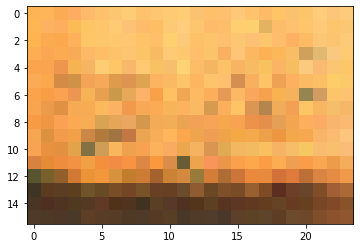

Step: 1000
Generator adv: -0.663, rec: 0.000
Critic fake: 0.587 real: -1.173 grad: 2.052
Steps per second: 13.53


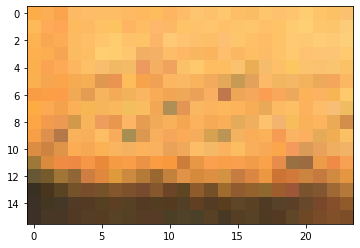

Step: 1500
Generator adv: -0.552, rec: 0.000
Critic fake: 0.577 real: -1.127 grad: 2.189
Steps per second: 13.00


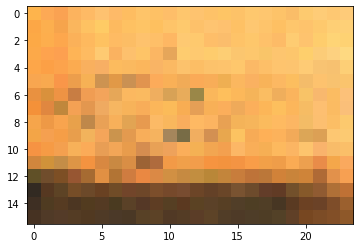

Reconstruction vs Original:


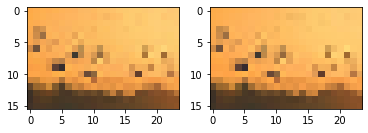

****************************
Scale 1
RMSE: 0.11
Generator norms: G0: 39.723, G1: 39.723
Critic norms: C0: 43.238, C1: 43.238
Step: 0
Generator adv: -0.363, rec: 0.241
Critic fake: 0.382 real: -0.678 grad: 0.861


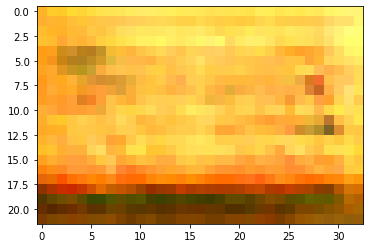

Step: 500
Generator adv: 0.007, rec: 0.001
Critic fake: -0.077 real: -0.370 grad: 1.638
Steps per second: 12.54


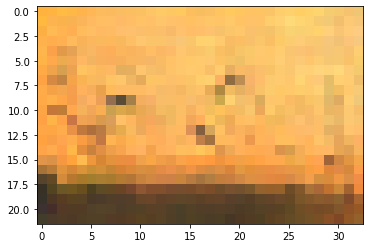

Step: 1000
Generator adv: -0.205, rec: 0.001
Critic fake: 0.223 real: -0.700 grad: 2.800
Steps per second: 13.46


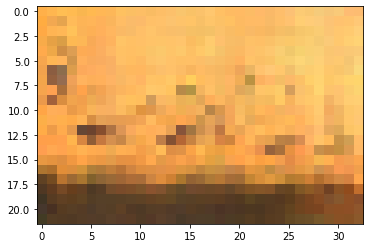

Step: 1500
Generator adv: -0.238, rec: 0.000
Critic fake: 0.232 real: -0.712 grad: 1.743
Steps per second: 13.47


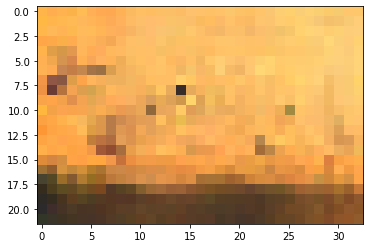

Reconstruction vs Original:


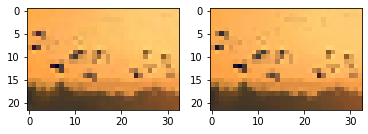

****************************
Scale 2
RMSE: 0.09
Generator norms: G0: 39.723, G1: 40.531, G2: 40.531
Critic norms: C0: 43.238, C1: 46.745, C2: 46.745
Step: 0
Generator adv: -0.155, rec: 0.015
Critic fake: 0.150 real: -0.255 grad: 0.653


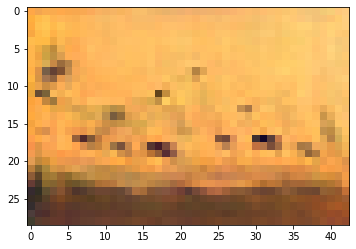

Step: 500
Generator adv: 0.429, rec: 0.001
Critic fake: -0.450 real: 0.147 grad: 0.586
Steps per second: 11.89


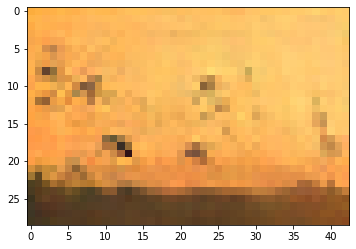

Step: 1000
Generator adv: 0.503, rec: 0.000
Critic fake: -0.504 real: 0.105 grad: 1.292
Steps per second: 11.62


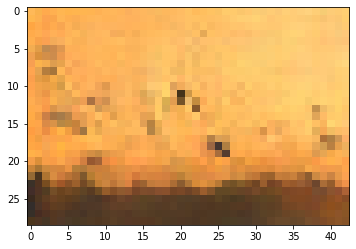

Step: 1500
Generator adv: 0.518, rec: 0.000
Critic fake: -0.520 real: 0.109 grad: 0.664
Steps per second: 11.70


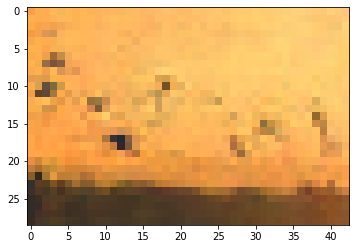

Reconstruction vs Original:


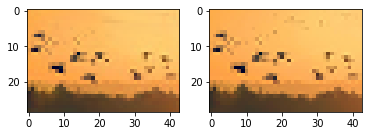

****************************
Scale 3
RMSE: 0.09
Generator norms: G0: 39.723, G1: 40.531, G2: 42.039, G3: 42.039
Critic norms: C0: 43.238, C1: 46.745, C2: 49.707, C3: 49.707
Step: 0
Generator adv: 0.622, rec: 0.012
Critic fake: -0.686 real: 0.606 grad: 0.615


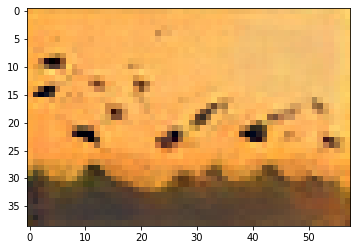

Step: 500
Generator adv: 1.182, rec: 0.001
Critic fake: -1.189 real: 0.938 grad: 1.277
Steps per second: 10.34


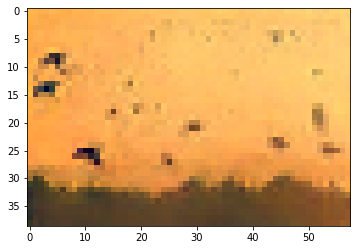

Step: 1000
Generator adv: 1.400, rec: 0.001
Critic fake: -1.409 real: 1.069 grad: 1.820
Steps per second: 10.56


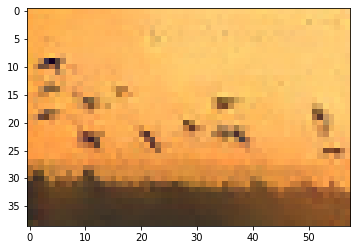

Step: 1500
Generator adv: 1.326, rec: 0.001
Critic fake: -1.318 real: 0.997 grad: 1.923
Steps per second: 10.66


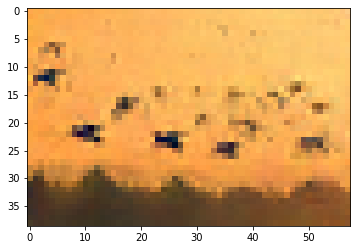

Reconstruction vs Original:


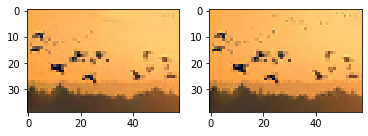

****************************
Scale 4
RMSE: 0.08
Generator norms: G0: 39.723, G1: 40.531, G2: 42.039, G3: 43.913, G4: 53.085
Critic norms: C0: 43.238, C1: 46.745, C2: 49.707, C3: 52.405, C4: 52.374
Step: 0
Generator adv: -0.168, rec: 0.071
Critic fake: -0.019 real: -0.215 grad: 0.517


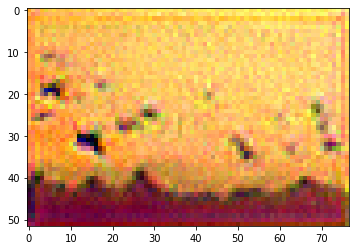

Step: 500
Generator adv: 1.470, rec: 0.002
Critic fake: -1.463 real: 1.210 grad: 1.388
Steps per second: 8.55


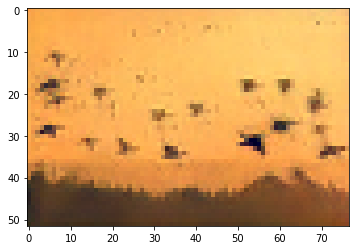

Step: 1000
Generator adv: 1.430, rec: 0.001
Critic fake: -1.423 real: 1.148 grad: 1.040
Steps per second: 8.48


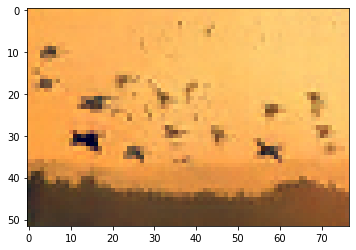

Step: 1500
Generator adv: 1.446, rec: 0.001
Critic fake: -1.437 real: 1.135 grad: 0.548
Steps per second: 8.50


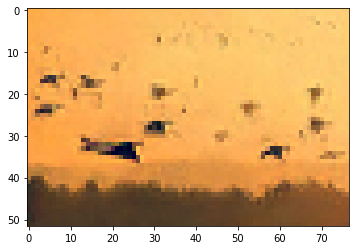

Reconstruction vs Original:


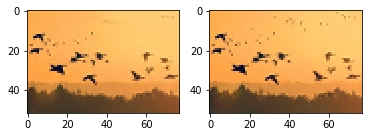

****************************
Scale 5
RMSE: 0.07
Generator norms: G0: 39.723, G1: 40.531, G2: 42.039, G3: 43.913, G4: 55.179, G5: 55.179
Critic norms: C0: 43.238, C1: 46.745, C2: 49.707, C3: 52.405, C4: 60.361, C5: 60.361
Step: 0
Generator adv: 1.433, rec: 0.008
Critic fake: -1.445 real: 1.393 grad: 0.662


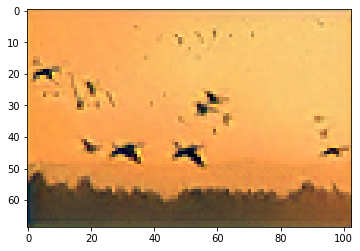

Step: 500
Generator adv: 0.997, rec: 0.001
Critic fake: -0.963 real: 0.720 grad: 1.060
Steps per second: 6.59


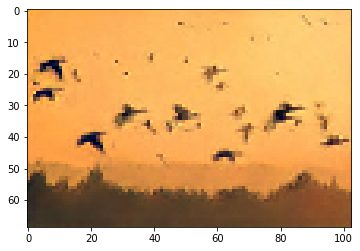

Step: 1000
Generator adv: 0.697, rec: 0.001
Critic fake: -0.707 real: 0.459 grad: 0.515
Steps per second: 6.56


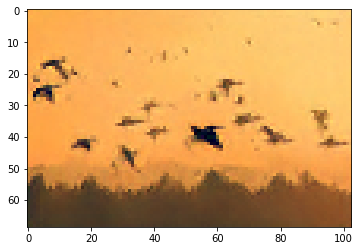

Step: 1500
Generator adv: 0.661, rec: 0.001
Critic fake: -0.697 real: 0.435 grad: 0.607
Steps per second: 6.57


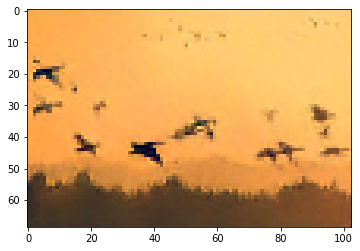

Reconstruction vs Original:


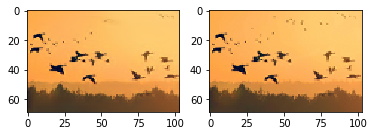

****************************
Scale 6
RMSE: 0.06
Generator norms: G0: 39.723, G1: 40.531, G2: 42.039, G3: 43.913, G4: 55.179, G5: 60.236, G6: 60.236
Critic norms: C0: 43.238, C1: 46.745, C2: 49.707, C3: 52.405, C4: 60.361, C5: 66.465, C6: 66.465
Step: 0
Generator adv: 0.590, rec: 0.006
Critic fake: -0.683 real: 0.653 grad: 0.294


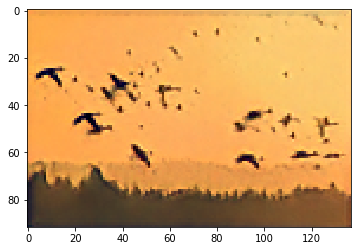

Step: 500
Generator adv: 0.211, rec: 0.001
Critic fake: -0.261 real: 0.160 grad: 0.333
Steps per second: 4.96


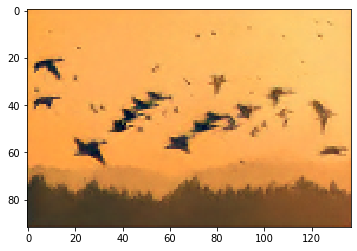

Step: 1000
Generator adv: 0.179, rec: 0.001
Critic fake: -0.173 real: -0.022 grad: 2.099
Steps per second: 4.89


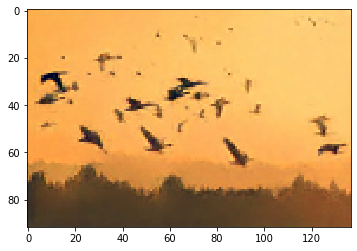

Step: 1500
Generator adv: 0.185, rec: 0.001
Critic fake: -0.186 real: -0.019 grad: 0.336
Steps per second: 4.90


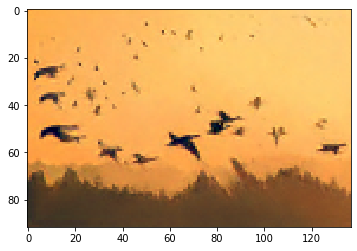

Reconstruction vs Original:


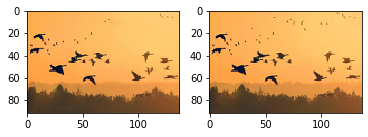

****************************
Scale 7
RMSE: 0.05
Generator norms: G0: 39.723, G1: 40.531, G2: 42.039, G3: 43.913, G4: 55.179, G5: 60.236, G6: 65.127, G7: 65.127
Critic norms: C0: 43.238, C1: 46.745, C2: 49.707, C3: 52.405, C4: 60.361, C5: 66.465, C6: 71.523, C7: 71.523
Step: 0
Generator adv: 0.130, rec: 0.004
Critic fake: -0.188 real: 0.159 grad: 0.189


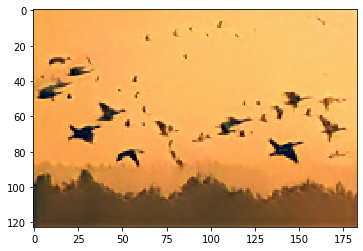

Step: 500
Generator adv: -0.087, rec: 0.001
Critic fake: 0.037 real: -0.170 grad: 0.902
Steps per second: 3.32


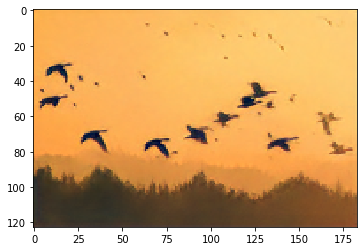

Step: 1000
Generator adv: -0.142, rec: 0.001
Critic fake: 0.159 real: -0.281 grad: 0.938
Steps per second: 3.22


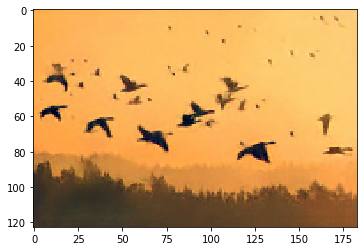

Step: 1500
Generator adv: -0.147, rec: 0.001
Critic fake: 0.146 real: -0.294 grad: 0.535
Steps per second: 3.27


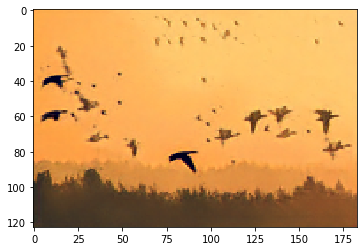

Reconstruction vs Original:


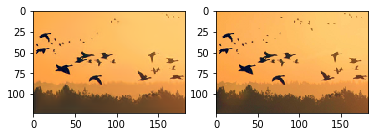

****************************
Scale 8
RMSE: 0.04
Generator norms: G0: 39.723, G1: 40.531, G2: 42.039, G3: 43.913, G4: 55.179, G5: 60.236, G6: 65.127, G7: 69.131, G8: 74.341
Critic norms: C0: 43.238, C1: 46.745, C2: 49.707, C3: 52.405, C4: 60.361, C5: 66.465, C6: 71.523, C7: 75.569, C8: 73.908
Step: 0
Generator adv: 0.026, rec: 0.143
Critic fake: -0.072 real: -0.127 grad: 0.300


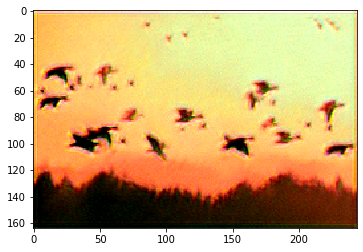

Step: 500
Generator adv: -0.238, rec: 0.001
Critic fake: 0.252 real: -0.269 grad: 0.189
Steps per second: 1.09


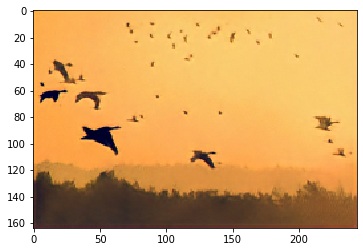

Step: 1000
Generator adv: -0.305, rec: 0.001
Critic fake: 0.303 real: -0.308 grad: 0.145
Steps per second: 1.09


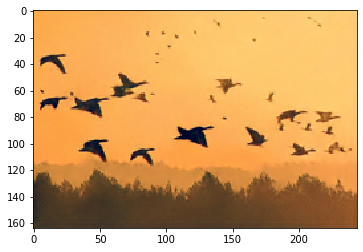

Step: 1500
Generator adv: -0.314, rec: 0.001
Critic fake: 0.314 real: -0.322 grad: 0.130
Steps per second: 1.09


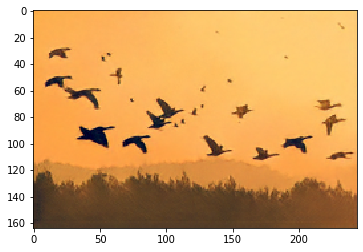

Reconstruction vs Original:


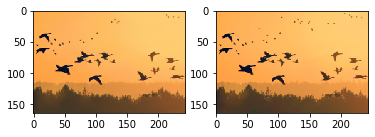

Total training time in hours: 1.13


In [0]:
# training cell
# loop values
training_start = time()
kernel_count = INITIAL_KERNEL_COUNT
generators, critics = [], []
gen_losses, crit_losses = [], []
for scale_index in range(NUM_SCALES):
  print('****************************\nScale {}'.format(scale_index))

  # get the original image at the current scale
  scale_orig_img = scaled_origs[scale_index]

  # things to be done after the first scale
  if scale_index > 0:
    # use RMSE to determine the standard deviation of the input noise
    with torch.no_grad():
      reconstruction = generator(z_rec)  # specific reconstruction noise
    scaled_reconstruction, _ = exact_interpolate(reconstruction, UPSAMPLING_FACTOR, exact_sizes[scale_index-1], UPSAMPLING_MODE)
    rmse = torch.sqrt(F.mse_loss(scaled_reconstruction, scale_orig_img))
    print('RMSE: {:.2f}'.format(rmse))
    # if the scale matches, increase kernel count
    if scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
      kernel_count *= 2
    # add a zero tensor to the reconstruction noise list
    # since it is defined as [z*, 0, 0, 0...] for some z*
    z_rec.append(torch.zeros_like(scale_orig_img))
      
  # create the noise sampler based on the RMSE
  # the first scale's stdev is different due to the zero input,
  # the noise has to be stronger than in the upper layers, although
  # this is alleviated by the rmse multiplier even if 
  # FIRST_SCALE_NOISE_STD == NOISE_BASE_STD
  scale_noise_std = FIRST_SCALE_NOISE_STD if scale_index == 0 else rmse * NOISE_BASE_STD

  ## initialize the generator
  # create a generator for this specific scale and initialize it
  scale_generator = make_generator(kernel_count, scale_noise_std)
  # copy weights from previous if possible, and add to the list
  initialize_net(scale_generator, generators)
  
  # create a single generator view from the stack of generators
  generic_generator = MultiScaleSGGenView(generators, UPSAMPLING_FACTOR, UPSAMPLING_MODE)
  # fix the input parameters for easier forward calls
  generator = FixedInputSGGenView(generic_generator, coarsest_zero_input, coarsest_exact_size)
  
  ## initialize the critic (discriminator)
  critic = make_critic(kernel_count)
  initialize_net(critic, critics)

  # create the optimizers and schedulers
  gen_optimizer, gen_sched = make_optimizer_and_scheduler(generator, GEN_LEARNING_RATE)
  crit_optimizer, crit_sched = make_optimizer_and_scheduler(critic, CRIT_LEARNING_RATE)

  # print norms to ensure correct operation
  gen_norms = ['G{}: {:.3f}'.format(i, sum_param_norms(g)) for i, g in enumerate(generators)]
  crit_norms = ['C{}: {:.3f}'.format(i, sum_param_norms(c)) for i, c in enumerate(critics)]
  print('Generator norms: ' + ', '.join(gen_norms))
  print('Critic norms: ' + ', '.join(crit_norms))
  
  # perform training
  for step in range(NUM_ITERS):

    for _ in range(CRIT_STEP_PER_ITER):
      crit_optimizer.zero_grad()
      
      # the model handles noise sampling on its own
      fake_img = generator()
      
      # gradient & adversarial loss
      grad_loss = gradient_penalty(critic, fake_img, scale_orig_img)
      fake_loss = critic(fake_img).mean()
      real_loss = -critic(scale_orig_img).mean()
      crit_loss = fake_loss + real_loss + GP_WEIGHT * grad_loss
      
      optimization_step(crit_loss, crit_optimizer, crit_sched, crit_losses)

    # zero gradient before beginning because
    # generator was used in the crit. training
    for _ in range(GEN_STEP_PER_ITER):
      gen_optimizer.zero_grad()

      fake_img = generator()

      # adversarial & reconstruction loss
      adv_loss = -critic(fake_img).mean()
      rec_img = generator(z_rec)
      rec_loss = F.mse_loss(scale_orig_img, rec_img)
      gen_loss = adv_loss + REC_ALPHA * rec_loss
      
      optimization_step(gen_loss, gen_optimizer, gen_sched, gen_losses)

    if step % PRINT_EVERY == 0:
      # print some details
      print('Step: {}'.format(step))
      print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.item(), rec_loss.item()))
      print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.item(), real_loss.item(), grad_loss.item()))
      if step != 0:
        elapsed = time() - last_print
        print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
        
      # example noise sample at highest scale
      with torch.no_grad():
        fake_example = generator()
      plt.imshow(normed_tensor_to_np_image(fake_example))
      plt.show()
      last_print = time()

  # show the reconstruction at the end of training
  print('Reconstruction vs Original:')
  with torch.no_grad():
    final_rec = generator(z_rec)
  plt.subplot(121)
  plt.imshow(normed_tensor_to_np_image(final_rec))
  plt.subplot(122)
  plt.imshow(normed_tensor_to_np_image(scale_orig_img))
  plt.show()

# save the model when done
save_model(SAVE_PATH, original_image, generators, critics, UPSAMPLING_FACTOR, UPSAMPLING_MODE, DOWNSAMPLING_MODE)

# show the total time the training took
training_duration = time() - training_start
print('Total training time in hours: {:.2f}'.format(training_duration / 3600))

# Load a Pre-trained Model and Sample Qualitative Results

Make sure to try this out with different pre-trained models and sizes! Sampling is fast even when using the CPU. Model names with a '9' suffix have been trained using 9 scales, and those with an '8' suffix have been trained using 8. Also note that the samples are random, and not hand-picked, which is why not all of them are entirely realistic.

Model: balloons9.pt


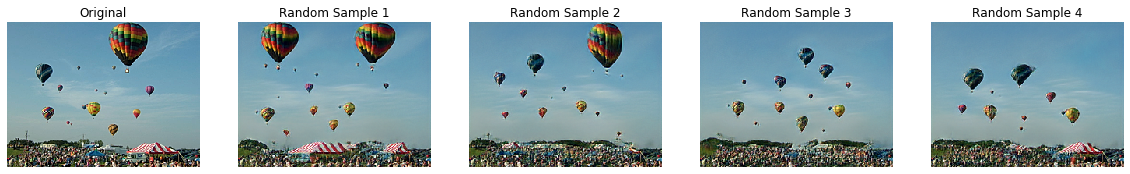

Model: birds8.pt


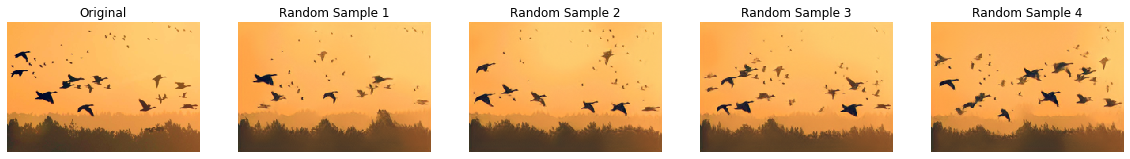

Model: birds9.pt


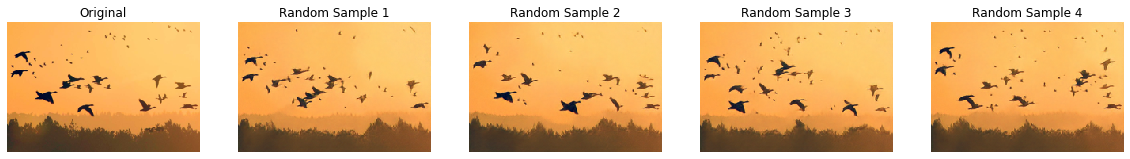

Model: colosseum9.pt


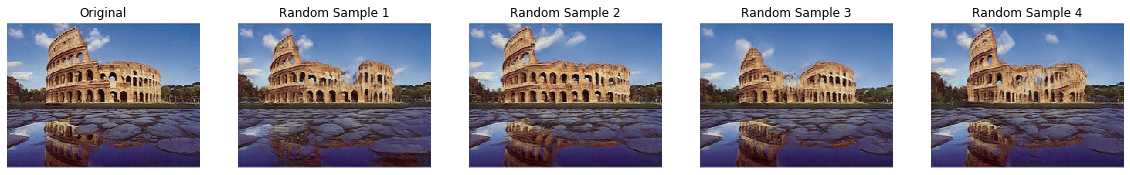

Model: lightning19.pt


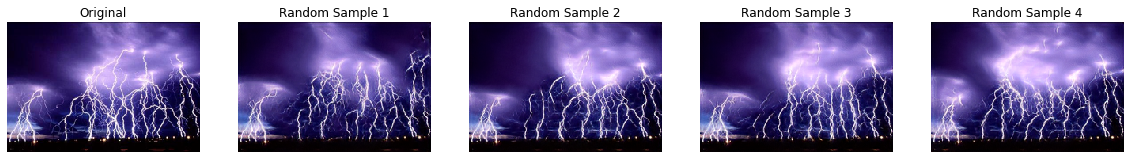

Model: mountains39.pt


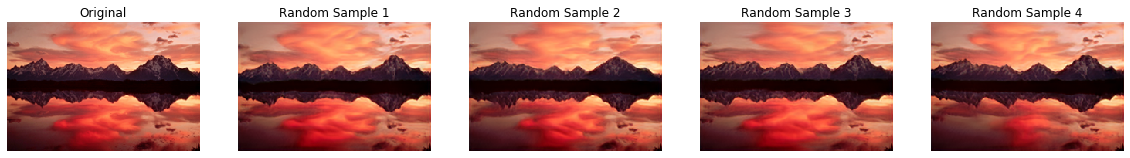

Model: mountains9.pt


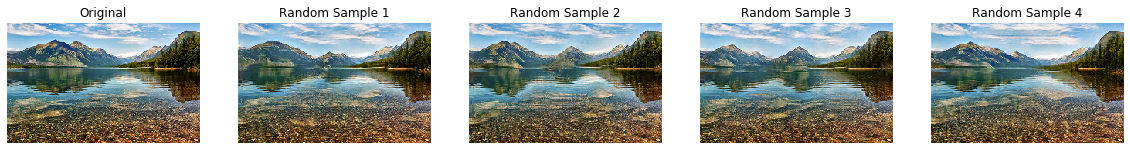

Model: volcano9.pt


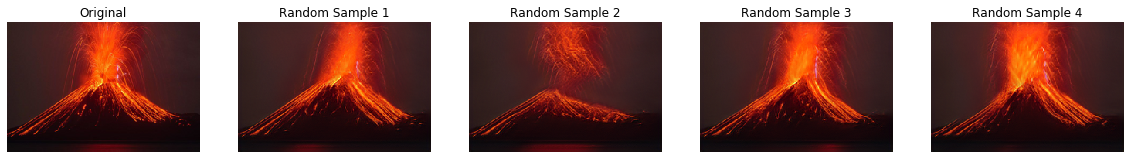

In [3]:
# training hyper-parameters have no effect here,
# all the necessary information is in the model file
MODEL_DIR = 'models'  # model file
NUM_SAMPLES = 4  # number of samples to display
INPUT_SCALE = 0  # input scale
OUTPUT_SIZE = None  # None keeps the size the model was trained with. Only works with input scale 0, try larger values such as (200, 1000)!
SEED = 42  # ideally, different from the one used in training
OUTPUT_FOLDER = 'samples'  # if not None, the folder is created and samples are saved

# about the INPUT_SCALE:
# 0 is coarsest, 1 one upper etc.
# when the input_scale > 0, the
# scaled original image is provided as
# input to the input_scale and lower
# scales are ignored entirely

# re-seed for reproducibility
seed_rngs(SEED)

# create the output folder
if OUTPUT_FOLDER:
  os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# set the figure size properly
prev_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (20, 10)

ncols = NUM_SAMPLES+1
entries = sorted(os.scandir(MODEL_DIR), key=lambda x: x.name)
for entry in entries:
  print('Model:', entry.name)
  # load the pre-trained model and maybe set-up custom input
  gen, original = load_generator(entry.path, INPUT_SCALE, OUTPUT_SIZE, device=DEVICE)

  ax = plt.subplot(1, ncols, 1)
  # show the original
  ax.title.set_text('Original')
  ax.axis('off')
  ax.imshow(normed_tensor_to_np_image(original))
  # add a sample to each subplot
  for i in range(NUM_SAMPLES):
    random_sample = gen()
    sample_uint = normed_tensor_to_np_image(random_sample)
    ax = plt.subplot(1, ncols, i+2)
    ax.axis('off')
    ax.title.set_text('Random Sample {}'.format(i+1))
    ax.imshow(sample_uint)
    # also save it if necessary
    save_path = os.path.join(OUTPUT_FOLDER, '{}-{}.png'.format(entry.name, i+1))
    Image.fromarray(sample_uint).save(save_path, 'PNG')
  plt.show()
  
# restore the previous figsize to not mess with other figures
plt.rcParams['figure.figsize'] = prev_figsize


# Quantitative Results

In this section, we aim to reproduce the results of Table 2 (page 7) in the original paper with our own implementation of SIFID (Single-Image Fréchet Inception Distance).

However, we cannot hope to reproduce the results exactly. This is because the authors calculated the SIFID values on a survey dataset they prepared for use on Amazon Mechanical Turk. There are 50 different images, with a single high variance and mid variance sample selected for each (probably the best sample they obtained from an unknown number of generated samples). Since we did not have the time to fully train fifty different models and select the best possible sample, we instead opted to do two different things, explained above each cell below.

### Important note:
- Due to an issue in scipy version 1.4+, loading the pre-trained inception model takes too long, and scipy has to be downgraded to 1.3 to ensure proper operation (see the related issue: https://discuss.pytorch.org/t/torchvisions-inception-v3-takes-much-longer-to-load-than-other-models/68756/12). If you are using your own computer, please configure the virtual environment accordingly. If you are using Google colab, you can use the following code cell to downgrade scipy (remember to restart your kernel/runtime afterwards!):

In [ ]:
# DO NOT RUN THIS CELL UNLESS NECESSARY, AS EXPLAINED ABOVE!!
!pip uninstall scipy -y
!pip install scipy==1.3.3
!pip list | grep scipy

### Initialization

In [3]:
from sifid import *

# the first time you run this cell, the pretrained inception model
# weights have to be downloaded (around 100 MB), so please be patient!

calc = SIFIDCalculator(DEVICE)

### Table 2 Reproduction

In this cell, we use the survey images provided by the authors of the paper on github. We calculate the pairwise SIFID values using our own implementation and ensure that it works, as we obtain the same results as shown in the paper on Table 2.

In [0]:
USER_STUDY_BASE = 'user study'
USER_STUDY_REAL = os.path.join(USER_STUDY_BASE, 'real')
USER_STUDY_MVAR = os.path.join(USER_STUDY_BASE, 'fake_mid_variance')
USER_STUDY_HVAR = os.path.join(USER_STUDY_BASE, 'fake_high_variance')

mid_sifid = calc.calculate_average_sifid_folders(USER_STUDY_REAL, USER_STUDY_MVAR)
high_sifid = calc.calculate_average_sifid_folders(USER_STUDY_REAL, USER_STUDY_HVAR)

print('SIFID at scale N (coarsest): {:.2f}'.format(round(high_sifid, 2)))
print('SIFID at scale N-1: {:.2f}'.format(round(mid_sifid, 2)))

SIFID at scale N (coarsest): 0.09
SIFID at scale N-1: 0.05


### SIFID on our own models
In this section, we manually calculate an average SIFID for each of the models we trained at different input scales over a number of samples. Then, we display each average SIFID on a table along with the average over all our models. Obviously the setting is a little different from the paper due to the small number of models we have, as well as some images having multiple models with different settings, and is also an average over multiple images per model rather than the best sample for each. But we believe that the results are similar enough for our purposes.

In [4]:
from tqdm import tqdm
MODEL_DIR = 'models'
SAMPLES_PER_MODEL = 50  # around 4 sec per model with a GPU, 5-10 times slower using CPU
SEED = 42  # yet another seed for reproducibility of the cell!

seed_rngs(SEED)

# calculate an average SIFID for each model and scale
sifids = []
scales = [0, 1]
entries = sorted(os.scandir(MODEL_DIR), key=lambda x: x.name)
for model_entry in tqdm(entries):
  row = []
  for input_scale in scales:
    gen, original = load_generator(model_entry.path, input_scale, device=DEVICE)
    avg_sifid = calc.calculate_average_sifid(gen, original, SAMPLES_PER_MODEL)
    row.append(avg_sifid)
  sifids.append(row)


100%|██████████| 8/8 [00:52<00:00,  6.55s/it]


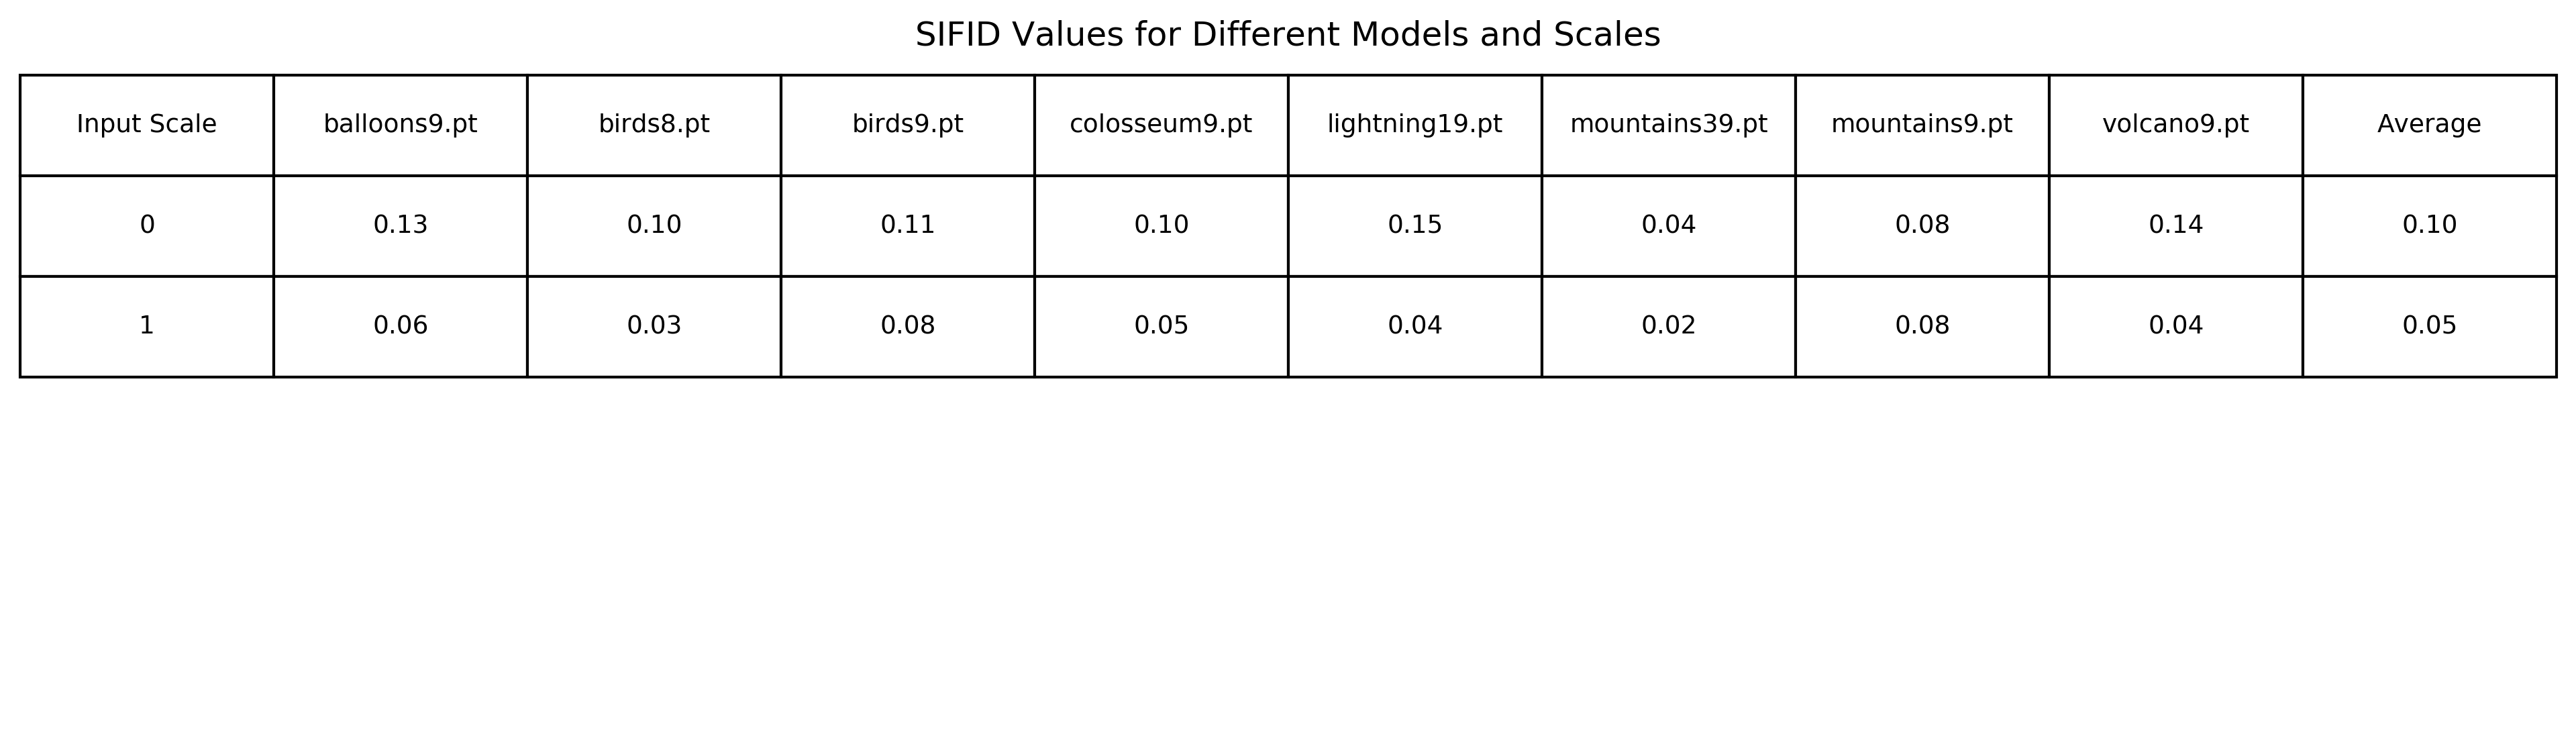

In [39]:
# calculate the average and round the values for printing
models = [entry.name for entry in entries]
average_per_scale = np.mean(sifids, axis=0, keepdims=True)
table_array = np.concatenate((sifids, average_per_scale), axis=0).transpose()
table_array = np.around(table_array, 2)

# format into table content
col_labels = ['Input Scale', *models, 'Average']
table_content = [[str(scale), *['{:.2f}'.format(x) for x in row]] for scale, row in zip(scales, table_array)]

# make the table using matplotlib
fig = plt.figure(1, figsize=(30, 10), dpi=300)
fig.subplots_adjust(left=0.2,top=0.8, wspace=1)
ax = plt.subplot2grid((4,3), (0,0), colspan=2, rowspan=2)
table = ax.table(cellText=table_content, colLabels=col_labels, cellLoc='center', loc='upper center')
ax.axis('off')
table.scale(1, 3)
plt.title('SIFID Values for Different Models and Scales')
plt.show()

# Implementation challenges

## Related to the paper

Thanks to the detailed treatment of the training process given by the authors both in the original paper and the paper's supplementary material (which can be accessed from the official webpage: https://webee.technion.ac.il/people/tomermic/SinGAN/SinGAN.htm), we knew most of the details before getting into the implementation and did not have too much difficulty, except for a few details: 

- The most difficult part for us was getting the gradient penalty right. The formulation in the original paper is pretty straightforward, the critic (discriminator) is viewed as a single function, and then the norm of its gradients is used for regularization. Note that the gradients have the shape of the network's input. Let's go over three increasingly difficult cases:
  - This is straightforward in the fully connected case, having an $(N, V)$ input with $N$ samples and $V$ dimensions, we can simply compute the norm over each sample and take their average. 
  - In the convolutional network case this gets a little more confusing, the input is $(N, C, H, W)$ with $C$ being the number of channels and $H$ and $W$ the dimensions (the output is still a scalar fakeness score). In this case, if we take the norm over the whole input (flatten all dimensions except the batch), the gradient norm scales with the size of the image. This can be offset with the multiplier of the gradient penalty in a setting where the input size never changes, but in our case we re-use the weights of the networks for different input images, which is why we need the output to not change too much with the dimensions. Thus, one correct approach is taking the norm only over the channel dimension and then averaging over every pixel of every sample.
  - Our case is not the simple discriminator case because we use a patch discriminator which has an image output. A simple approach might be taking the mean of this output to obtain a single scalar, and then apply the standard discriminator approach. However, this fails our purpose, because we take the mean both before getting the gradient and afterwards, which means that our gradient norm will become smaller with larger input sizes rather than not change. Instead, we need to take the sum of the discriminator's output rather than the mean, so that the mean is applied only once. This was the part that took us the longest to figure out before getting the gradient penalty right.
- One small missing detail was the number of scales used in image generation. Although the paper's supplementary material provides this detail for the 'Applications' (superres, editing, harmonization etc.) section, the number of scales used for generating the images in  Figures 1 and 6 is not provided. Since 8 and 9 are referenced often, we tried both and decided to use 9 in general since it provided more varied outputs.
- Another trivial missing detail was that the upsampling and downsampling techniques used were not specified. We opted to use bicubic interpolation to downsample the original images so as to preserve their quality as well as possible, and chose bilinear interpolation when upsampling generator outputs to allow more liberty for the generators in modifying their inputs.

We did face a few more issues during the implementation which caused us to chase bugs for a while, but those were not related to the paper or lack of information; they were simply our own small coding mistakes.